In [3]:
using CSV
using DataFrames
using Plots
using Measures

In [2]:
include("../src/julia/dcopf.jl");

In [ ]:
# Run the model for all years
scenario = 11
gen_prop_name = "liu_etal_2024"
bus_prop_name = "liu_etal_2024"
branch_prop_name = "liu_etal_2024"
out_path = "./out/Scenario$(scenario)/";

for year in 1998:2019
    println("Running scenario $(scenario) for year $(year)")
    run_model(scenario, year, gen_prop_name, branch_prop_name, bus_prop_name, out_path)
end

In [13]:
function get_loadshed_metrics(directory_path, varname)
    # Define the years you have run the model for
    years = 1998:2019
    num_years = length(years)
    num_qms = 48  # Number of quarter months in a year
    
    # Read the quarter month to number of days mapping
    dayofqm = CSV.read("../data_tmp/qm_to_numdays.csv", DataFrame)
    nhours = dayofqm.Days .* 24  # Convert days to hours
    cum_nhours = cumsum(nhours)  # Cumulative hours to map time steps
    
    # Directory where the load shedding results are stored
    lhscenario = 4  # Adjust this if your scenario number is different
    
    metrics = Dict{String, Matrix}()
    
    # Initialize matrices to hold the results
    total_load_shedding = zeros(num_years, num_qms)
    max_hourly_load_shedding = zeros(num_years, num_qms)
    num_hours_load_shedding = zeros(num_years, num_qms)
    
    # Loop over each year to process load shedding data
    for (i, year) in enumerate(years)
        # Construct the file path for the current year's load shedding data
        # loadshed_file = "$(directory_path)/load_shedding_$(year).csv"
        loadshed_file = "$(directory_path)/$(varname)_$(year).csv"
    
        # Read the load shedding data for the current year
        loadshed_df = CSV.read(loadshed_file, DataFrame, header=false)
        loadshed = Matrix(loadshed_df)
    
        # Sum load shedding over all buses for each hour
        total_loadshed_per_hour = sum(loadshed, dims=1)  # Result is 1 x nt
    
        # Process each quarter month
        for q in 1:num_qms
            # Determine the start and end indices for the current quarter month
            if q == 1
                start_idx = 1
            else
                start_idx = cum_nhours[q-1] + 1
            end
        end_idx = cum_nhours[q]
        
        # Ensure indices are integers
        start_idx = Int(start_idx)
        end_idx = Int(end_idx)
        
        # Extract the load shedding data for the current quarter month
        ls_qm = total_loadshed_per_hour[1, start_idx:end_idx]
        
        # Compute total load shedding for the quarter month
        total_ls = sum(ls_qm)
        total_load_shedding[i, q] = total_ls
        
        # Compute maximum hourly load shedding for the quarter month
        max_ls = maximum(ls_qm)
        max_hourly_load_shedding[i, q] = max_ls
        
        # Compute number of hours with load shedding in the quarter month
        num_hours_ls = count(ls_qm .> 0)
        num_hours_load_shedding[i, q] = num_hours_ls
        end
    end
    
    merge!(metrics, Dict(
        "total_load_shedding" => total_load_shedding, 
        "max_hourly_load_shedding" => max_hourly_load_shedding, 
        "num_hours_load_shedding" => num_hours_load_shedding))
end;

In [12]:
# Reproduce figure 1 from paper
scenario = 11
directory_path_julia = "./out/Scenario$(scenario)/"
varname_julia = "load_shedding"

directory_path_matlab = "/Users/dcl257/Projects/current_projects/nys_comparison/data_vivienne_hopper/SimulationResults/Scenario11"
varname_matlab = "loadshed"

metrics_julia = get_loadshed_metrics(directory_path_julia, varname_julia)
metrics_matlab = get_loadshed_metrics(directory_path_matlab, varname_matlab)
metrics_diff = Dict(
    "total_load_shedding" => metrics_julia["total_load_shedding"] - metrics_matlab["total_load_shedding"],
    "max_hourly_load_shedding" => metrics_julia["max_hourly_load_shedding"] - metrics_matlab["max_hourly_load_shedding"],
    "num_hours_load_shedding" => metrics_julia["num_hours_load_shedding"] - metrics_matlab["num_hours_load_shedding"]);


In [10]:
metrics_matlab

Dict{String, Matrix} with 3 entries:
  "total_load_shedding"      => [33977.1 46802.6 … 83139.9 2.62956e5; 4.25527e5…
  "max_hourly_load_shedding" => [5387.37 6214.11 … 9825.99 10106.5; 13178.6 470…
  "num_hours_load_shedding"  => [11.0 20.0 … 23.0 100.0; 90.0 61.0 … 37.0 59.0;…

In [11]:
metrics_julia

Dict{String, Matrix} with 3 entries:
  "total_load_shedding"      => [18522.8 51069.8 … 1.05604e5 2.4499e5; 4.21907e…
  "max_hourly_load_shedding" => [2492.22 6860.02 … 11314.5 9949.81; 13919.8 353…
  "num_hours_load_shedding"  => [10.0 20.0 … 50.0 88.0; 82.0 60.0 … 35.0 66.0; …

In [9]:
metrics_diff

Dict{String, Matrix{Float64}} with 3 entries:
  "total_load_shedding"      => [-15454.3 4267.19 … 22464.3 -17966.1; -3620.12 …
  "max_hourly_load_shedding" => [-2895.15 645.912 … 1488.47 -156.644; 741.267 -…
  "num_hours_load_shedding"  => [-1.0 0.0 … 27.0 -12.0; -8.0 -1.0 … -2.0 7.0; ……

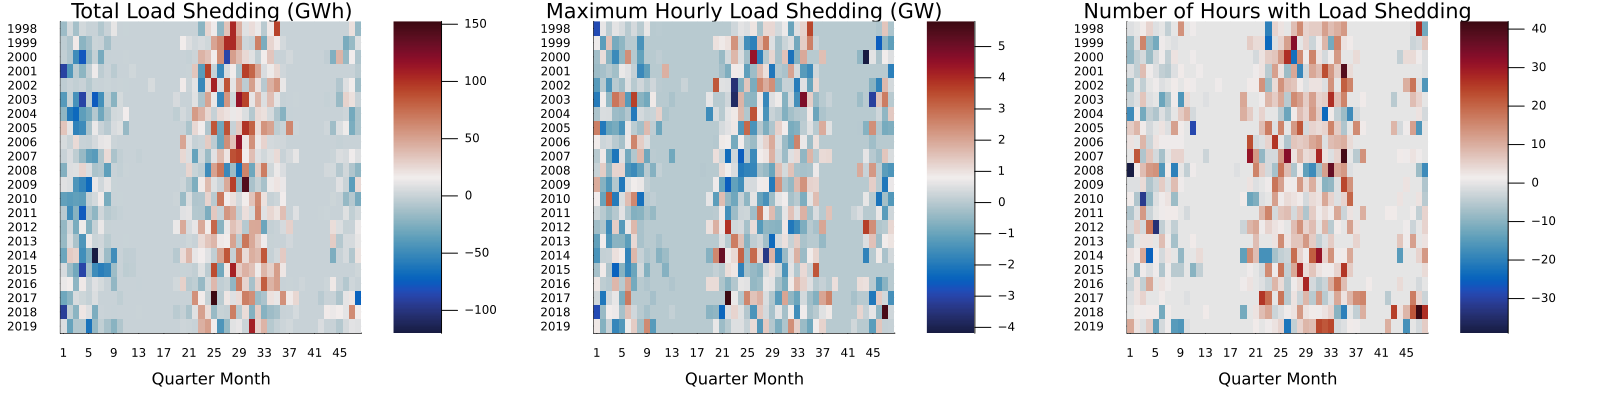

In [ ]:
metrics = metrics_diff

# Prepare labels for the heatmaps
year_labels = string.(years)
qm_labels = 1:4:num_qms

# Set up plotting parameters
default(size=(1600, 400))

# Plot all three heatmaps in a single figure using subplots
plot(
    heatmap(
        metrics["total_load_shedding"]/1000,
        xlabel="Quarter Month",
        ylabel="",
        title="Total Load Shedding (GWh)",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true,
        colormap = :balance,
        colorrange = (-1, 1) .* maximum(abs, metrics["total_load_shedding"]/1000)
    ),
    heatmap(
        metrics["max_hourly_load_shedding"]/1000,
        xlabel="Quarter Month",
        ylabel="",
        title="Maximum Hourly Load Shedding (GW)",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true,
        colormap = :balance,
        colorrange = (-1, 1) .* maximum(abs, metrics["max_hourly_load_shedding"]/1000)
    ),
    heatmap(
        metrics["num_hours_load_shedding"],
        xlabel="Quarter Month",
        ylabel="",
        title="Number of Hours with Load Shedding",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true,
        colormap = :balance,
        colorrange = (-1, 1) .* maximum(abs, metrics["num_hours_load_shedding"])
    ),
    layout=(1, 3),
    bottom_margin=10mm
)

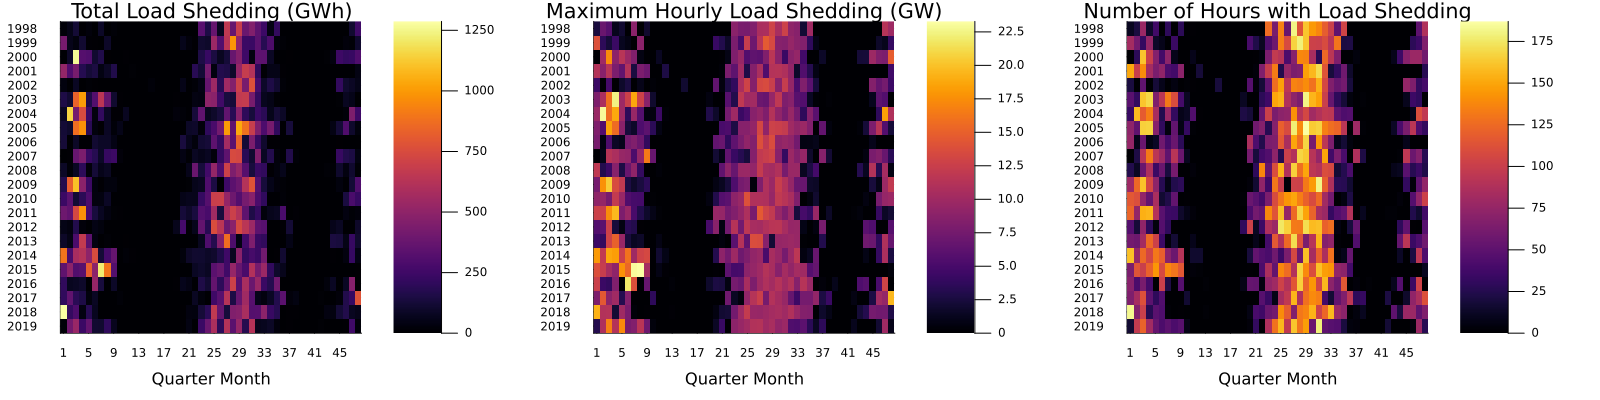

In [18]:
metrics = metrics_julia

# Prepare labels for the heatmaps
year_labels = string.(years)
qm_labels = 1:4:num_qms

# Set up plotting parameters
default(size=(1600, 400))

# Plot all three heatmaps in a single figure using subplots
plot(
    heatmap(
        metrics["total_load_shedding"]/1000,
        xlabel="Quarter Month",
        ylabel="",
        title="Total Load Shedding (GWh)",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true
    ),
    heatmap(
        metrics["max_hourly_load_shedding"]/1000,
        xlabel="Quarter Month",
        ylabel="",
        title="Maximum Hourly Load Shedding (GW)",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true
    ),
    heatmap(
        metrics["num_hours_load_shedding"],
        xlabel="Quarter Month",
        ylabel="",
        title="Number of Hours with Load Shedding",
        xticks=(1:4:num_qms, qm_labels),
        yticks=(1:num_years, year_labels),
        cbar_title="",
        yflip=true
    ),
    layout=(1, 3),
    bottom_margin=10mm
)